<a href="https://colab.research.google.com/github/mdr356/tensorflow-dog-cat-cnn/blob/master/tensorflow_dog_cat_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

**Downloading Dog and Cat images**
The dataset we have downloaded has the following directory structure.
cats_and_dogs_filtered
```
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
```

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**file path for the training and validation sets.**

In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

# print number of data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000



Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

* Read images from the disk
* Decode contents of these images and convert it into proper grid format as per their RGB content
* Convert them into floating point tensors
* Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


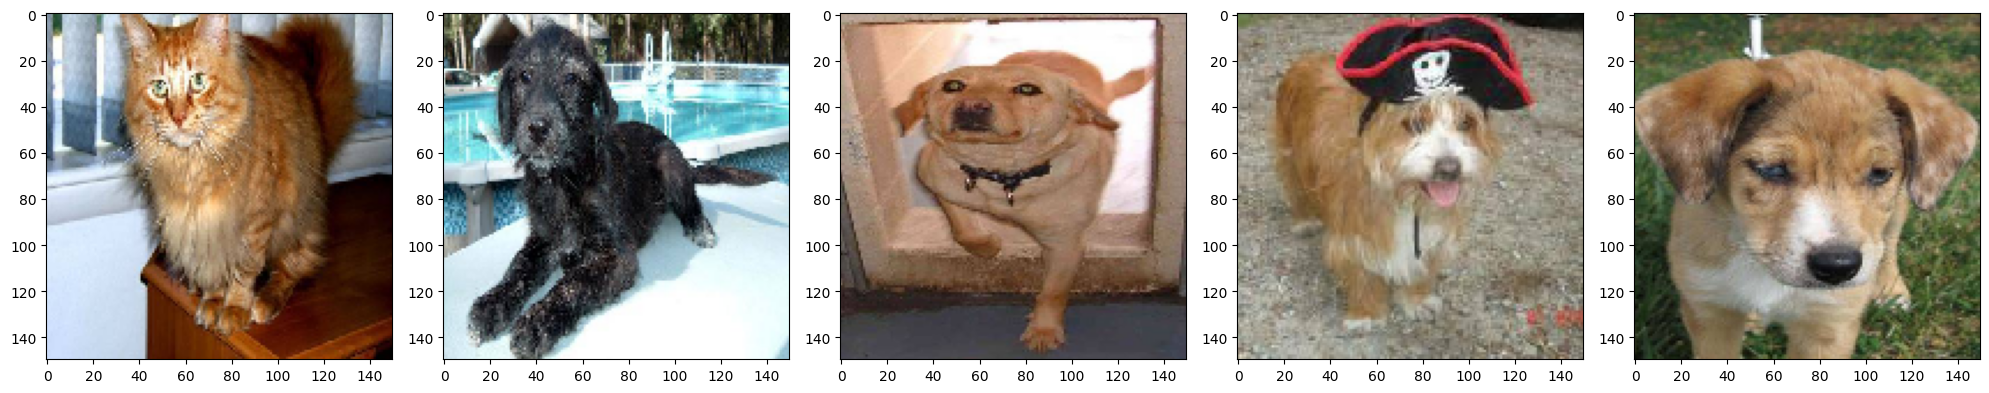

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# After defining our generators for training and validation images,
## flow_from_directory method will load images from the disk,
### apply rescaling, and resize them using single line of code.

train_data_gen = train_image_generator.flow_from_directory(batch_size=100,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')
validation_data_gen = validation_image_generator.flow_from_directory(batch_size=100,
                                                                     directory=validation_dir,
                                                                     shuffle=False,
                                                                     target_size=(150, 150),
                                                                     class_mode='binary')

#plotting the image
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])  # Plot images 0-4

**Model**
Create a sequensial model with Con2D of 32 followed by MaxPooling 2x2 with a stride of 2. which will be followed by another set of Conv2D with output of 64 and maxpooling then go up to 128 units of Con2D and Maxpooling. We will then flatten the data from 2D to 1D array, follow by a fully connected layer and a dense layer output of 2 wiht softmax activiation.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the data
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(100))),
    epochs=100,
    validation_data=validation_data_gen,
    validation_steps=int(np.ceil(total_val / float(100)))
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/20 ━━━━━━━━━━━━━━━━━━━━ 52s 7s/step - accuracy: 0.5257 - loss: 1.7199 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

**Cats and Dogs with Image Augmentation**
This is so we can prevent overfitting, which is when the model starts remembering the training data and does not do well when it sees new data. We use data augmentatoin with ImageDataGenerator to flip, zoom, shift randomly some of the images in order to train. We also use validataion data which model has not seen to validate.

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


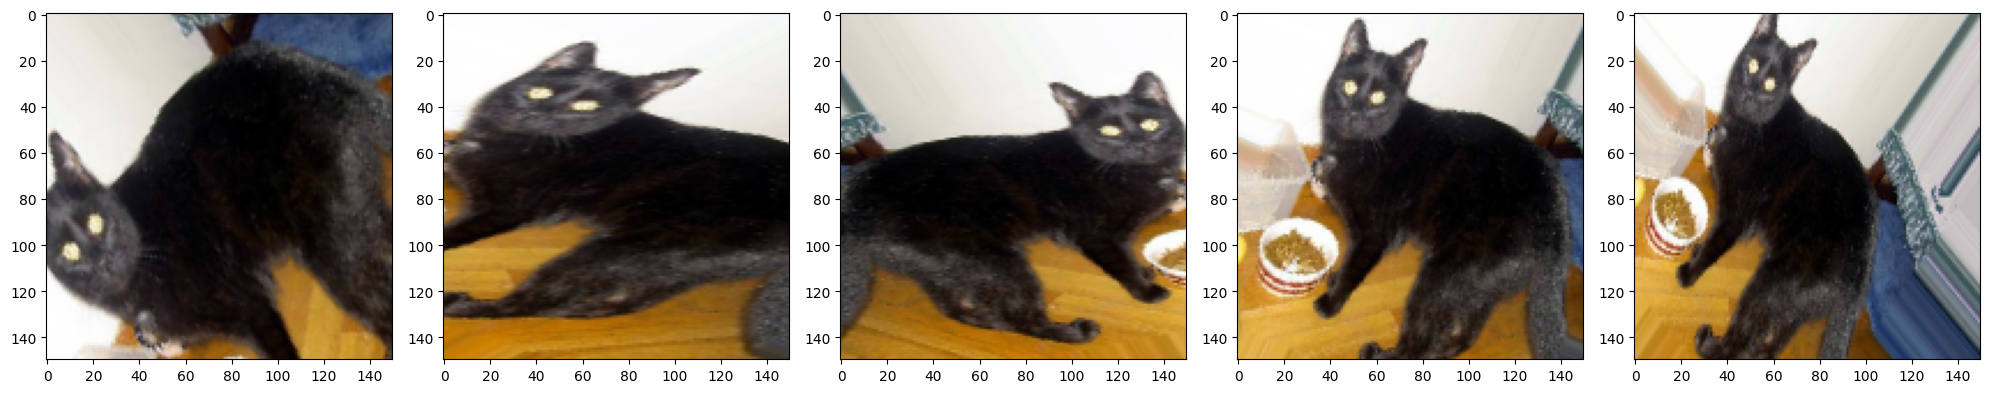

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,634 (13.17 MB)

 Trainable params: 3,453,634 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 454ms/step - accuracy: 0.5034 - loss: 0.7617 - val_accuracy: 0.5020 - val_loss: 0.6905
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.5302 - loss: 0.6908 - val_accuracy: 0.6210 - val_loss: 0.6783
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step - accuracy: 0.5690 - loss: 0.6841 - val_accuracy: 0.6330 - val_loss: 0.6658
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.5959 - loss: 0.6740 - val_accuracy: 0.5960 - val_loss: 0.6774
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.6089 - loss: 0.6729 - val_accuracy: 0.6520 - val_loss: 0.6450
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 450ms/step - accuracy: 0.6242 - loss: 0.6576 - val_accuracy: 0.6400 - val_loss: 0.6271
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 437ms/step - accuracy: 0.6383 - loss: 0.6243 - val_accuracy: 0.6770 - val_loss: 0.6104
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.6523 - loss: 0.6205 - val_accuracy

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)


base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

# print number of data
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)
IMAGE_SHAPE = 150

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

BATCH_SIZE = 100
EPOCH = 100
# adding features to add augmentation so we don't have daga overfitting.
image_gen = ImageDataGenerator(rescale= 1./255,
                                horizontal_flip=True, # random horizontal flip of images
                                rotation_range=45, # random rotating to a number of degree
                                zoom_range=0.5, # random zooming to a number of degree
                                width_shift_range=0.15, # random width shift
                                height_shift_range=0.15, #
                                fill_mode='nearest')
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
                                               class_mode='binary')

image_gen_val = ImageDataGenerator(rescale=1./255)
validation_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=validation_dir,
                                                   target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
                                                   class_mode='binary')

augmented_images1 = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images1)

# MODEL
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # adding a dropout layer where 50% of any neurons get drop whose weights are too high.
    tf.keras.layers.Dropout(0.5),
    #flatten image from 2D to 1D
    tf.keras.layers.Flatten(),
    # fully connected layer
    tf.keras.layers.Dense(512, activation='relu'),
    # softmax is used for categorical. If I used sigmoid which is used for binary classification. but softmax is my go to.
    tf.keras.layers.Dense(2)
])

# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

steps_per_epoch = len(train_data_gen)//BATCH_SIZE

validation_steps = len(validation_data_gen)//BATCH_SIZE # if you have validation data

# train the data
history = model.fit(
    train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCH,
    validation_data=validation_data_gen,
    validation_steps=validation_steps
)


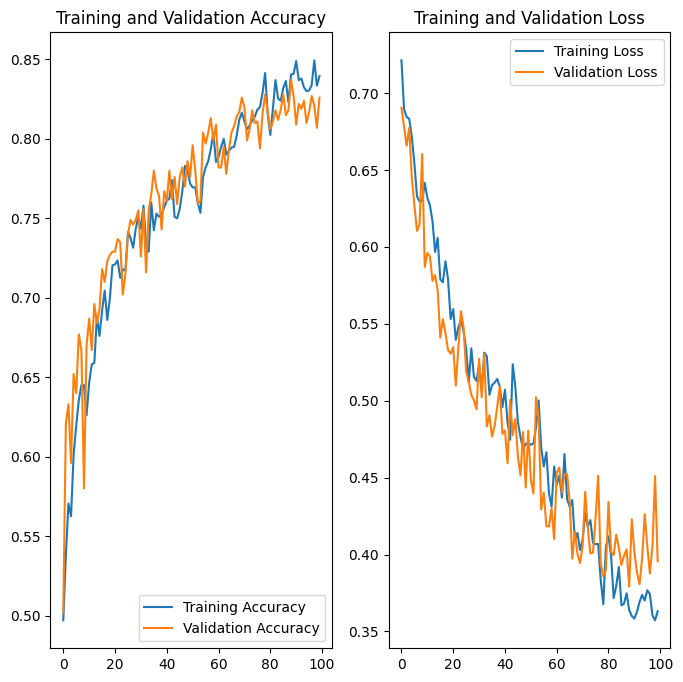

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCH)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()